In [1]:
import os
os.environ["KMP_DUPLICATE_LIB_OK"] = "TRUE"


In [2]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import numpy as np
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from tqdm import tqdm

In [3]:
import pandas as pd

# Login using e.g. `huggingface-cli login` to access this dataset
df = pd.read_csv("Cleaned Sentiment140 Dataset with Tokenized Sequences.csv")

In [4]:
# Custom Dataset Class
class TwitterDataset(Dataset):
    def __init__(self, sequences, labels):
        self.sequences = sequences
        self.labels = labels

    def __len__(self):
        return len(self.sequences)

    def __getitem__(self, idx):
        return torch.tensor(self.sequences[idx], dtype=torch.long), torch.tensor(self.labels[idx], dtype=torch.long)


In [5]:
# Custom Transformer Model
class CustomTransformer(nn.Module):
    def __init__(self, vocab_size, embed_dim=128, n_heads=4, num_layers=2, max_len=40, num_classes=2):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, embed_dim, padding_idx=0)
        self.pos_embedding = nn.Parameter(torch.randn(1, max_len, embed_dim))
        encoder_layer = nn.TransformerEncoderLayer(d_model=embed_dim, nhead=n_heads)
        self.encoder = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)
        self.classifier = nn.Linear(embed_dim, num_classes)

    def forward(self, x):
        x = self.embedding(x) + self.pos_embedding[:, :x.size(1), :]
        x = self.encoder(x)
        x = x.mean(dim=1)
        return self.classifier(x)

In [6]:
df = df.dropna(subset=["sentiment label", "listed text"])
df = df[df["sentiment label"].isin(["Positive", "Neutral", "Negative"])]

# Convert stringified list to actual list
df["listed text"] = df["listed text"].apply(eval)

In [7]:
df.head()

,Unnamed: 0,sentiment,tweet_id,date,flag,user,text,sentiment label,masked text,listed text,truncated sequences,tokenized sequences
0,0,0,1467810369,Mon Apr 06 22:19:45 PDT 2009,NO_QUERY,_TheSpecialOne_,"[USER] [URL] - Aww, that's a bummer. You shou...",Negative,"[USER] [URL] - Aww, that's a bummer. You shou...","[[USER], [URL], -, Aww, that, s, a, bummer, Yo...","[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14..."
1,1,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by ...,Negative,is upset that he can't update his Facebook by ...,"[is, upset, that, he, can, t, update, his, Fac...","[20, 21, 5, 22, 23, 24, 25, 26, 27, 28, 29, 19...","[20, 21, 5, 22, 23, 24, 25, 26, 27, 28, 29, 19..."
2,2,0,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,[USER] I dived many times for the ball. Manage...,Negative,[USER] I dived many times for the ball. Manage...,"[[USER], I, dived, many, time, for, the, ball,...","[1, 38, 39, 40, 41, 42, 43, 44, 45, 17, 46, 47...","[1, 38, 39, 40, 41, 42, 43, 44, 45, 17, 46, 47..."
3,3,0,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire,Negative,my whole body feels itchy and like its on fire,"[my, whole, body, feel, itchy, and, like, it, ...","[52, 53, 54, 55, 56, 30, 57, 19, 58, 59, '[PAD...","[52, 53, 54, 55, 56, 30, 57, 19, 58, 59, '[PAD..."
4,4,0,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,"[USER] no, it's not behaving at all. i'm mad. ...",Negative,"[USER] no, it's not behaving at all. i'm mad. ...","[[USER], no, it, s, not, behaving, at, all, i,...","[1, 60, 19, 6, 61, 62, 63, 64, 65, 66, 67, 68,...","[1, 60, 19, 6, 61, 62, 63, 64, 65, 66, 67, 68,..."


In [13]:
# Label encoding
label_encoder = LabelEncoder()
df["label"] = label_encoder.fit_transform(df["sentiment label"])  # Positive = 1, Negative = 0

# Token Indexing
token2index = {tok: idx+1 for idx, tok in enumerate({t for d in df["listed text"] for t in d})}
token2index["[PAD]"] = 0
index2token = {v: k for k, v in token2index.items()}

In [14]:
def doc_to_idx(doc):
    return [token2index.get(tok, 0) for tok in doc]

def pad_seq(seq, max_len=40):
    return seq[:max_len] + [0] * (max_len - len(seq)) if len(seq) < max_len else seq[:max_len]


In [15]:
df["sequence"] = df["listed text"].apply(doc_to_idx).apply(lambda x: pad_seq(x, max_len=40))

# Train/test split

In [16]:
X_train, X_val, y_train, y_val = train_test_split(df["sequence"].tolist(), df["label"].tolist(), test_size=0.2)

In [17]:
# Create Datasets
train_dataset = TwitterDataset(X_train, y_train)
val_dataset = TwitterDataset(X_val, y_val)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=64)


In [18]:
# === Model Setup ===
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = CustomTransformer(vocab_size=len(token2index), num_classes=2).to(device)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)


C:\Users\natal\miniconda3\lib\site-packages\torch\nn\modules\transformer.py:379: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(


In [20]:
from tqdm import tqdm

def train_model(
    model,
    train_loader,
    val_loader,
    criterion,
    optimizer,
    device,
    epochs=5,
    print_metrics=True
):
    model.to(device)
    metrics_log = {
        "train_loss": [],
        "val_accuracy": [],
        "val_precision": [],
        "val_recall": [],
        "val_f1": []
    }

    for epoch in range(epochs):
        model.train()
        total_loss = 0
        train_bar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{epochs} [Training]", leave=False)

        for batch_x, batch_y in train_bar:
            batch_x, batch_y = batch_x.to(device), batch_y.to(device)

            optimizer.zero_grad()
            outputs = model(batch_x)
            loss = criterion(outputs, batch_y)
            loss.backward()
            optimizer.step()

            total_loss += loss.item()
            train_bar.set_postfix(loss=loss.item())

        avg_loss = total_loss / len(train_loader)

        # === Validation Phase ===
        model.eval()
        all_preds = []
        all_labels = []

        val_bar = tqdm(val_loader, desc=f"Epoch {epoch+1}/{epochs} [Validation]", leave=False)
        with torch.no_grad():
            for batch_x, batch_y in val_bar:
                batch_x, batch_y = batch_x.to(device), batch_y.to(device)
                outputs = model(batch_x)
                preds = torch.argmax(outputs, dim=1)
                all_preds.extend(preds.cpu().tolist())
                all_labels.extend(batch_y.cpu().tolist())

        # Metrics
        val_acc = accuracy_score(all_labels, all_preds)
        precision = precision_score(all_labels, all_preds, average='macro', zero_division=0)
        recall = recall_score(all_labels, all_preds, average='macro', zero_division=0)
        f1 = f1_score(all_labels, all_preds, average='macro', zero_division=0)

        # Log metrics
        metrics_log["train_loss"].append(avg_loss)
        metrics_log["val_accuracy"].append(val_acc)
        metrics_log["val_precision"].append(precision)
        metrics_log["val_recall"].append(recall)
        metrics_log["val_f1"].append(f1)

        if print_metrics:
            print(f"\nEpoch {epoch+1}/{epochs}")
            print(f"Train Loss: {avg_loss:.4f} | Val Acc: {val_acc:.4f}")
            print(f"Precision: {precision:.4f} | Recall: {recall:.4f} | F1 Score: {f1:.4f}\n")

    return model, metrics_log


## With Attention

In [21]:
import torch
import torch.nn as nn

class CustomCausalTransformer(nn.Module):
    def __init__(self, vocab_size, embed_dim=128, n_heads=4, num_layers=2, max_len=40, num_classes=3, causal=False):
        super().__init__()
        self.causal = causal
        self.max_len = max_len

        self.embedding = nn.Embedding(vocab_size, embed_dim, padding_idx=0)
        self.pos_embedding = nn.Parameter(torch.randn(1, max_len, embed_dim))

        encoder_layer = nn.TransformerEncoderLayer(d_model=embed_dim, nhead=n_heads)
        self.encoder = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)

        self.classifier = nn.Linear(embed_dim, num_classes)

    def generate_causal_mask(self, seq_len, device):
        mask = torch.triu(torch.ones(seq_len, seq_len), diagonal=1)
        mask = mask.masked_fill(mask == 1, float('-inf')).to(device)
        return mask

    def forward(self, x):
        # x: (batch_size, seq_len)
        batch_size, seq_len = x.shape

        x = self.embedding(x) + self.pos_embedding[:, :seq_len, :]

        # Generate attention mask (optional)
        if self.causal:
            attn_mask = self.generate_causal_mask(seq_len, x.device)  # shape [seq_len, seq_len]
        else:
            attn_mask = None

        x = self.encoder(x.transpose(0, 1), mask=attn_mask)  # shape [seq_len, batch_size, embed_dim]
        x = x.transpose(0, 1)  # back to [batch_size, seq_len, embed_dim]

        pooled = x.mean(dim=1)  # mean pooling over sequence
        return self.classifier(pooled)


In [19]:
# For sentiment classification with causal masking ON
model = CustomCausalTransformer(
    vocab_size=len(token2index),
    embed_dim=128,
    n_heads=4,
    num_layers=4,
    max_len=40,
    num_classes=3,     # 3 for positive/neutral/negative
    causal=True        # Set to False for bidirectional attention (like BERT)
)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr= 0.0001)

model, log = train_model(
    model, train_loader, val_loader,
    criterion, optimizer,
    device='cuda' if torch.cuda.is_available() else 'cpu',
    epochs=2
)



Epoch 1/2
Train Loss: 0.5116 | Val Acc: 0.7829
Precision: 0.7835 | Recall: 0.7828 | F1 Score: 0.7827




Epoch 2/2
Train Loss: 0.4419 | Val Acc: 0.7981
Precision: 0.7993 | Recall: 0.7981 | F1 Score: 0.7979



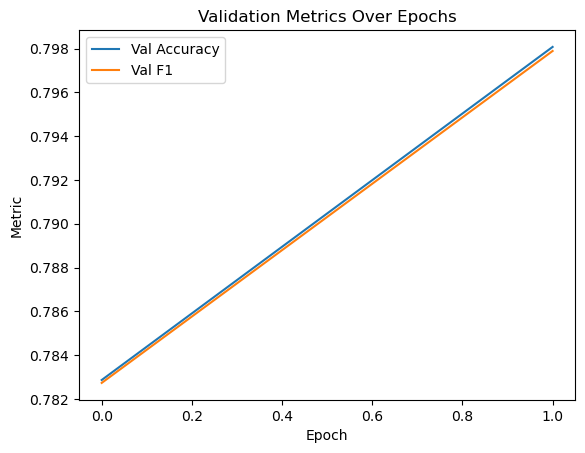

In [20]:
import matplotlib.pyplot as plt

plt.plot(log["val_accuracy"], label="Val Accuracy")
plt.plot(log["val_f1"], label="Val F1")
plt.xlabel("Epoch")
plt.ylabel("Metric")
plt.legend()
plt.title("Validation Metrics Over Epochs")
plt.show()


In [21]:
# For sentiment classification with causal masking ON
model = CustomCausalTransformer(
    vocab_size=len(token2index),
    embed_dim=16,
    n_heads=2,
    num_layers=2,
    max_len=40,
    num_classes=3,     # 3 for positive/neutral/negative
    causal=True        # Set to False for bidirectional attention (like BERT)
)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr= 0.001)

model, log = train_model(
    model, train_loader, val_loader,
    criterion, optimizer,
    device='cuda' if torch.cuda.is_available() else 'cpu',
    epochs=2
)


C:\Users\natal\miniconda3\lib\site-packages\torch\nn\modules\transformer.py:379: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(
IOPub message rate exceeded.█████████                                 | 4854/20625 [13:19<41:28,  6.34it/s, loss=0.436]
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)

IOPub message rate exceeded.██████████████████████▍                  | 11479/20625 [29:50<22:04,  6.91it/s, loss=0.412]
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Cur


Epoch 1/2
Train Loss: 0.4879 | Val Acc: 0.7919
Precision: 0.7926 | Recall: 0.7918 | F1 Score: 0.7917



IOPub message rate exceeded.██████████████▎                           | 7362/20625 [18:32<33:49,  6.54it/s, loss=0.516]
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)

IOPub message rate exceeded.█████████████████████████                | 12804/20625 [33:01<20:21,  6.40it/s, loss=0.307]
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)

                                                                                                                       


Epoch 2/2
Train Loss: 0.4325 | Val Acc: 0.7982
Precision: 0.7993 | Recall: 0.7982 | F1 Score: 0.7980



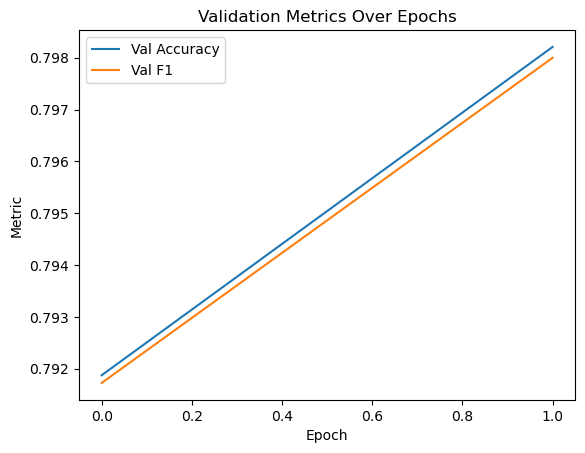

In [22]:
plt.plot(log["val_accuracy"], label="Val Accuracy")
plt.plot(log["val_f1"], label="Val F1")
plt.xlabel("Epoch")
plt.ylabel("Metric")
plt.legend()
plt.title("Validation Metrics Over Epochs")
plt.show()


In [22]:
# For sentiment classification with causal masking ON
model = CustomCausalTransformer(
    vocab_size=len(token2index),
    embed_dim=8,
    n_heads=4,
    num_layers=4,
    max_len=40,
    num_classes=3,     # 3 for positive/neutral/negative
    causal=True        # Set to False for bidirectional attention (like BERT)
)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr= 0.001)

model, log = train_model(
    model, train_loader, val_loader,
    criterion, optimizer,
    device='cuda' if torch.cuda.is_available() else 'cpu',
    epochs=2
)


C:\Users\natal\miniconda3\lib\site-packages\torch\nn\modules\transformer.py:379: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(
                                                                                                                       


Epoch 1/2
Train Loss: 0.6126 | Val Acc: 0.7014
Precision: 0.7033 | Recall: 0.7012 | F1 Score: 0.7005




Epoch 2/2
Train Loss: 0.5782 | Val Acc: 0.6969
Precision: 0.6979 | Recall: 0.6967 | F1 Score: 0.6963



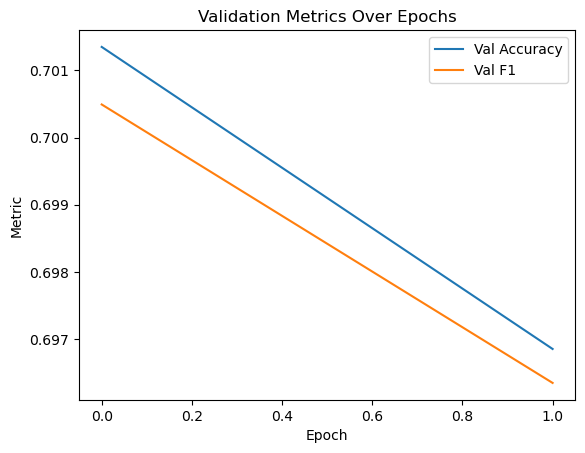

In [26]:
import matplotlib.pyplot as plt

plt.plot(log["val_accuracy"], label="Val Accuracy")
plt.plot(log["val_f1"], label="Val F1")
plt.xlabel("Epoch")
plt.ylabel("Metric")
plt.legend()
plt.title("Validation Metrics Over Epochs")
plt.show()


In [ ]:
def evaluate_model(model, test_loader, threshold=0.5, device='cpu'):
    model.eval()
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for batch in test_loader:
            inputs, labels = batch
            inputs, labels = inputs.to(device), labels.to(device)

            outputs = model(inputs)
            preds = torch.sigmoid(outputs).view(-1)
            preds = (preds >= threshold).long()

            all_preds.extend(preds.cpu().tolist())
            all_labels.extend(labels.cpu().tolist())

    accuracy = accuracy_score(all_labels, all_preds)
    precision = precision_score(all_labels, all_preds)
    recall = recall_score(all_labels, all_preds)
    f1 = f1_score(all_labels, all_preds)

    print(f"\nEvaluation:")
    print(f"Accuracy:  {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall:    {recall:.4f}")
    print(f"F1 Score:  {f1:.4f}")

    return all_preds, all_labels, accuracy, precision, recall, f1

In [36]:
def evaluate_model(model, test_loader, threshold=0.5, device='cpu'):
    model.eval()
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for batch in test_loader:
            inputs, labels = batch
            inputs, labels = inputs.to(device), labels.to(device)
    
            outputs = model(inputs)  # shape [batch_size, 3]
            preds = torch.argmax(outputs, dim=1)  # shape [batch_size]
    
            all_preds.extend(preds.cpu().tolist())
            all_labels.extend(labels.cpu().tolist())
    
    
        accuracy = accuracy_score(all_labels, all_preds)
        precision = precision_score(all_labels, all_preds)
        recall = recall_score(all_labels, all_preds)
    f1 = f1_score(all_labels, all_preds)

    print(f"\nEvaluation:")
    print(f"Accuracy:  {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall:    {recall:.4f}")
    print(f"F1 Score:  {f1:.4f}")

    return all_preds, all_labels, accuracy, precision, recall, f1

In [37]:
all_preds, all_labels, accuracy, precision, recall, f1 = evaluate_model(model, val_loader, threshold=0.5, device='cpu')


Evaluation:
Accuracy:  0.6969
Precision: 0.7113
Recall:    0.6586
F1 Score:  0.6840


In [38]:
''' DATA VISUALIZATION '''
import seaborn as sb
from wordcloud import WordCloud
import matplotlib.pyplot as plt
import pyLDAvis
import graphviz
from mpl_toolkits.mplot3d import Axes3D 
from mpl_toolkits.mplot3d import Axes3D 
from IPython.display import Image
import pydotplus
from matplotlib.ticker import MultipleLocator
from matplotlib.ticker import AutoMinorLocator
from tabulate import tabulate
from sklearn.metrics import confusion_matrix
from sklearn.utils.multiclass import unique_labels

In [39]:

def visual_confusion_matrix(labels, predictions ,title, label_name, file_name, fig_x, fig_y):
    sb.set_style("white")
    sb.set(font='Times New Roman', font_scale=1)
    fig, ax = plt.subplots(figsize=(fig_x, fig_y)) 
    ax.set_facecolor('white')


    if isinstance(labels, torch.Tensor):
        labels = labels.cpu().numpy()
    if isinstance(predictions, torch.Tensor):
        predictions = predictions.cpu().numpy()

    unique_labels = sorted(set(labels) | set(predictions))

    
    text_labels = list(label_encoder.inverse_transform(unique_labels))
    
    matrix_ = confusion_matrix(labels, predictions, labels = unique_labels)
    
    confusion_df = pd.DataFrame(matrix_, index=unique_labels, columns=unique_labels)
        
    
    sb.heatmap(confusion_df, annot = True, fmt='d', xticklabels=text_labels, yticklabels=text_labels, cbar_kws={'shrink': 0.5}, ax=ax)
    ax.set_title(f"Confusion Matrix:\n{title}\nLabels: {label_name}")
    ax.set_ylabel("True Labels")
    ax.set_xlabel("Predicted Labels")
    
    ax.set_aspect('equal', adjustable='box')
    #plt.subplots_adjust(left=0.15, right=0.85, top=0.85, bottom=0.15)
    
    # Save and show the plot
    
    plt.tight_layout(pad=.5)
    plt.savefig(file_name, dpi=600)
    
    plt.show()

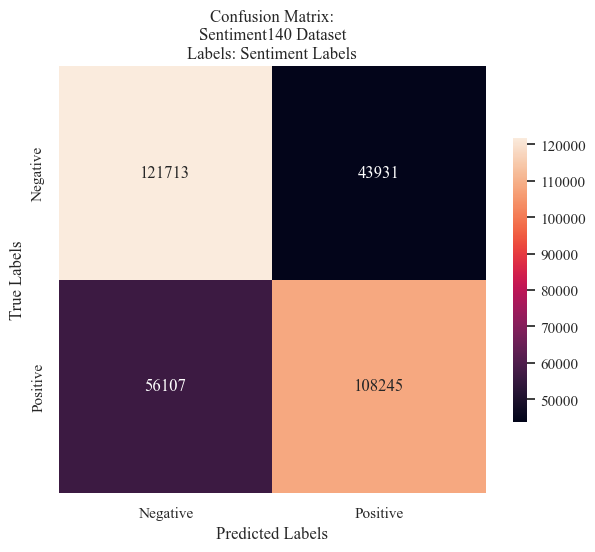

In [40]:
visual_confusion_matrix(all_labels, all_preds, 'Sentiment140 Dataset', 'Sentiment Labels', 'confusion matrix.png', 6,6)